In [9]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
import torch


def get_flow_matching_path_mu(
    targets: torch.Tensor, noise: torch.Tensor, time_steps: torch.Tensor
):
    # Ensure targets and noise have the same shape
    assert (
        targets.shape == noise.shape
    ), f"targets: {targets.shape}, noise: {noise.shape}"

    # Print shapes for debugging
    print(f"targets: {targets.shape}")  # (batch_size, features)
    print(f"noise: {noise.shape}")  # (batch_size, features)
    print(f"time_steps: {time_steps.shape}")  # (n_timesteps,)

    # Reshape time_steps for broadcasting: (batch_size, 1)
    time_steps = time_steps.view(-1, 1)

    # Element-wise operations
    temp_1 = time_steps * targets  # broadcasting time_steps across features
    print(f"temp_1: {temp_1.shape}")  # (batch_size, features)

    temp_2 = (1 - time_steps) * noise
    print(f"temp_2: {temp_2.shape}")  # (batch_size, features)

    # Return the interpolated result
    return temp_1 + temp_2


In [95]:
device = "cpu"

n_samples = 100
n_timesteps = 10
sigma = 0.01
inputs_ = torch.linspace(-torch.pi, torch.pi, n_samples)
x = torch.sin(inputs_)

data = torch.cat([inputs_.unsqueeze(1), x.unsqueeze(1)], dim=1)


<Axes: xlabel='None', ylabel='None'>

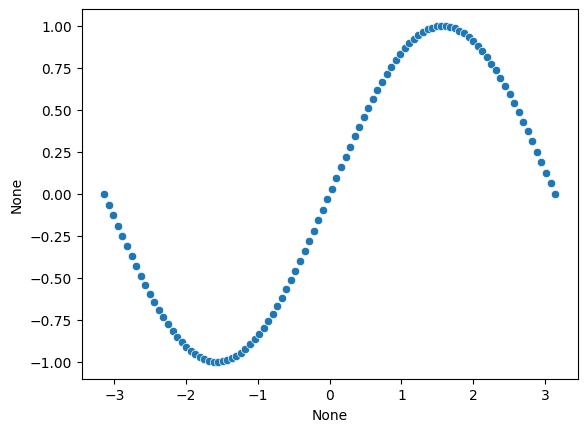

In [96]:
sns.scatterplot(x=data[:,0], y=data[:, 1])

In [97]:
x = data
noise = torch.randn_like(x)
ts = torch.linspace(0, 1, n_timesteps)


mu = get_flow_matching_path_mu(targets=x, noise=noise, time_steps=ts)

print(f"mu shape: {mu.shape}")

# sample a random value of t from a uniform distribution for each batch element
reparam_noise = torch.randn_like(mu)

sample_x = mu + sigma * reparam_noise

print(f"sample_x shape: {sample_x.shape}")



targets: torch.Size([100, 2])
noise: torch.Size([100, 2])
time_steps: torch.Size([10])


RuntimeError: The size of tensor a (10) must match the size of tensor b (100) at non-singleton dimension 0

In [61]:

for i in range(10):
    sns.scatterplot(mu[i, 0], mu[i, 1], label=f"sample {i}", alpha=(i + 1) / 11)

plt.legend()
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given